https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

Description: 

Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:
1) Location
2) Tweet At
3) Original Tweet
4) Label




Reference notebook wheen having issues ; https://www.kaggle.com/anubhavsanyal/tensorflow-with-lstm-83-accuracy

In [3]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [372]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow imports

# for building model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout,BatchNormalization

# for Padding
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for Tokenization 
from tensorflow.keras.preprocessing.text import Tokenizer

# NLTK imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# For regular expressions
import re

# For data preprocessing
from string import punctuation, digits

# For wordclouds 
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub

In [185]:
data_dir = 'gdrive/MyDrive/Covid19_Tweets'
train = pd.read_csv(data_dir + '/Corona_NLP_train.csv',encoding="Latin-1")
test  = pd.read_csv(data_dir + '/Corona_NLP_test.csv',encoding="Latin-1")

Checking the strucutre of the train and test dataset 

In [186]:
print(f'Number of trainaing examples : {len(train)}')
print(f'Number of validation examples : {len(test)}')

Number of trainaing examples : 41157
Number of validation examples : 3798


In [187]:
print(train.head())
print(test.head())
# We have equal number of examples in the training and testing set , we might have 
# to add some examples to increase the length of the trainaing set

   UserName  ...           Sentiment
0      3799  ...             Neutral
1      3800  ...            Positive
2      3801  ...            Positive
3      3802  ...            Positive
4      3803  ...  Extremely Negative

[5 rows x 6 columns]
   UserName  ...           Sentiment
0         1  ...  Extremely Negative
1         2  ...            Positive
2         3  ...  Extremely Positive
3         4  ...            Negative
4         5  ...             Neutral

[5 rows x 6 columns]


**Exploratory Data Analysis **

In [188]:
print('Number of unique classes are :' , train['Sentiment'].nunique())

Number of unique classes are : 5


Text(0, 0.5, '')

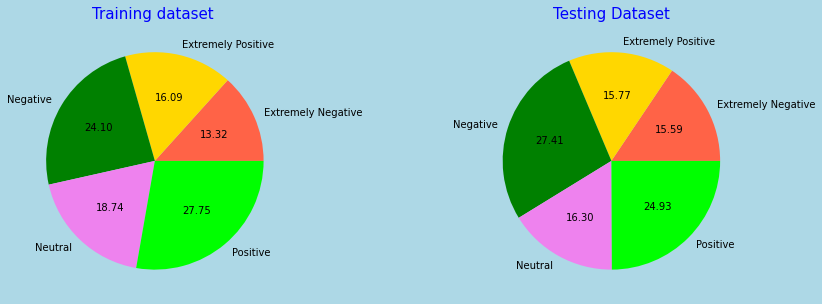

In [189]:
# Visualizing the number of examples for each class 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.patch.set_facecolor('lightblue')
train.groupby('Sentiment').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 10},
                                  colors=['tomato', 'gold', 'green','violet', 'lime'], ax=ax1)
test.groupby('Sentiment').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 10},
                                 colors=['tomato', 'gold', 'green','violet', 'lime'], ax=ax2)

ax1.set_title('Training dataset ', size=15,color='blue')
ax2.set_title('Testing Dataset', size=15,color='blue')
ax1.set_ylabel('')
ax2.set_ylabel('')

**The distribution of classes seem to evenly distributed in both the training and testing sets , so it's better to leave as it is for now.**

**Time series exploration**

In [190]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'])
test['TweetAt'] = pd.to_datetime(test['TweetAt'])
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       3798 non-null   int64         
 1   ScreenName     3798 non-null   int64         
 2   Location       2964 non-null   object        
 3   TweetAt        3798 non-null   datetime64[ns

In [191]:
# Time Range of tweets 
print('Start Date for training tweets : ' , train['TweetAt'].min())
print('End Date for training tweets : ' , train['TweetAt'].max())
print('Range for training tweets : ', (train['TweetAt'].max() -  train['TweetAt'].min()).days)
print('Start Date for testing tweets : ' , test['TweetAt'].min())
print('End Date for testing tweets : ' , test['TweetAt'].max())
print('Range for testing tweets : ', (test['TweetAt'].max() -  train['TweetAt'].min()).days)

Start Date for training tweets :  2020-01-04 00:00:00
End Date for training tweets :  2020-12-04 00:00:00
Range for training tweets :  335
Start Date for testing tweets :  2020-02-03 00:00:00
End Date for testing tweets :  2020-12-03 00:00:00
Range for testing tweets :  334


**Merging the extreme cases with their parent class**

In [192]:
for i in range(0,len(train)):
    if(train['Sentiment'][i]=='Extremely Negative'):
        train['Sentiment'][i]='Negative'
    elif(train['Sentiment'][i]=='Extremely Positive'):
        train['Sentiment'][i]='Positive'

for i in range(0,len(test)):
    if(test['Sentiment'][i]=='Extremely Negative'):
        test['Sentiment'][i]='Negative'
    elif(test['Sentiment'][i]=='Extremely Positive'):
        test['Sentiment'][i]='Positive'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__'

In [193]:
print('Number of unique classes are :' , train['Sentiment'].nunique())

Number of unique classes are : 3


*The range for both the training and testing sets is starting and ending at the same time period , so there shouldn't be a case for seasonal bias. We can leave that as it is for now. * *italicized text*

In [194]:
for idx, num in enumerate(train['Location'].unique()):
  print(num)
  if idx >=20:
    break
# As seen the locations are not that relevant to see , 
# it's random and hence is not useful for analysis. It's better to drop that column 
# so as the username and screenname it's better to drop these columns 

train.drop(['UserName','ScreenName','Location'],inplace=True,axis=1)
test.drop(['UserName','ScreenName','Location'],inplace=True,axis=1)
print(train.info())
print(test.info())

London
UK
Vagabonds
nan
ÃT: 36.319708,-82.363649
35.926541,-78.753267
Austria
Atlanta, GA USA
BHAVNAGAR,GUJRAT
Makati, Manila
Pitt Meadows, BC, Canada 
Horningsea
Chicago, IL
Houston, Texas
Saudi Arabia
Ontario, Canada
North America
Denver, CO
southampton soxx xxx
Global
Downstage centre
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TweetAt        41157 non-null  datetime64[ns]
 1   OriginalTweet  41157 non-null  object        
 2   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 964.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TweetAt        3798 non-null   datetime64[ns]
 1   OriginalTweet  37

**Data Preprocessing **

In [195]:
train['OriginalTweet'][0] # If you see the sentence below or the tweet it doesn't really give much information about the sentiments 

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [196]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

# Remove letter ' â ' in words
def rem_latin_a(sentences):
    sentences = sentences.replace("â", "")
    return sentences
def remove_unicode(string_unicode):
  string_encode = string_unicode.encode("ascii", "ignore")
  string_decode = string_encode.decode()
  return string_decode

In [197]:
nltk.download('stopwords')

train.OriginalTweet = train.OriginalTweet.apply(lambda sentences:rem_latin_a(sentences))
test.OriginalTweet = test.OriginalTweet.apply(lambda sentences:rem_latin_a(sentences))
train.OriginalTweet = train.OriginalTweet.apply(lambda sentences:clean_sentence(sentences))
test.OriginalTweet = test.OriginalTweet.apply(lambda sentences:clean_sentence(sentences))
train.OriginalTweet = train.OriginalTweet.apply(lambda sentences:remove_unicode(sentences))
test.OriginalTweet = test.OriginalTweet.apply(lambda sentences:remove_unicode(sentences))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [198]:
train['OriginalTweet'][0] # If you see the sentence below or the tweet it doesn't really give much information about the sentiments 

''

So there maybe many tweets like these which are broken down into empty strings after text cleaning ; we can try to replcae these with np.nan values and then remove all of them as they are not significant for our analysis

In [199]:
# Discard null values

train = train[train['OriginalTweet'] != '']
test = test[test['OriginalTweet'] != '']

# Originally there were 41157 rows, now it has become 41106. The training dataset was reduced by 51 lines.
train.dropna(subset=['OriginalTweet'], inplace=True)

# Originally there were 3798 lines, now it has become 3795. The test dataset was reduced by 3 lines.
test.dropna(subset=['OriginalTweet'], inplace=True)

print(f'Number of trainaing examples : {len(train)}')
print(f'Number of validation examples : {len(test)}')

Number of trainaing examples : 41106
Number of validation examples : 3795


**Visaualizing and seeing which words are most frequently used in each of the classes**

In [200]:
def wordcloud(sentiment):
  text = ''
  train_sentence = list(train[train['Sentiment'] == 'Positive'].OriginalTweet)
  test_sentence = list(test[test['Sentiment'] == 'Positive'].OriginalTweet)
  for s in train_sentence:
    text += s 
  for s in test_sentence:
    text += s 
  wordcloud = WordCloud(max_font_size=50, max_words=50,width=480,height=480 ,background_color="black",colormap="Blues").generate(text)
  plt.figure(figsize=(12,8))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(sentiment + ' Reviews Word cloud',color='blue')
  plt.show()

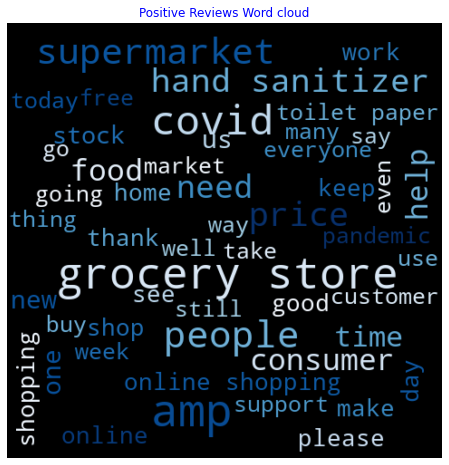

In [201]:
wordcloud('Positive')

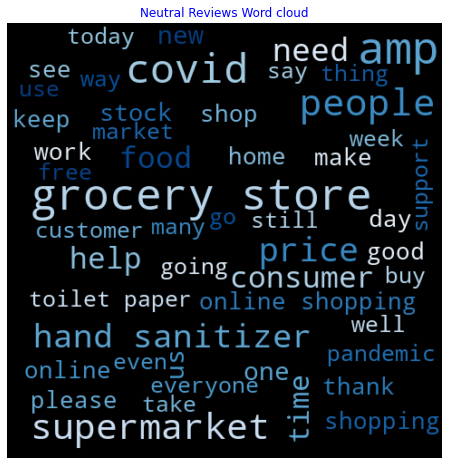

In [202]:
wordcloud('Neutral')

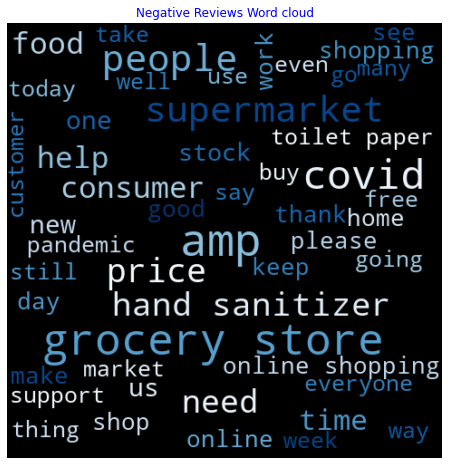

In [203]:
wordcloud('Negative')

**Lemmatization **

In [204]:
lemmatizer = WordNetLemmatizer()

# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function below is necessery to find lemma of each word
def lemmatize_sentence(de_punct_sent):
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(de_punct_sent))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # If there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [205]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
train.OriginalTweet = train.OriginalTweet.apply(lambda sentences:lemmatize_sentence(sentences))
test.OriginalTweet = test.OriginalTweet.apply(lambda sentences:lemmatize_sentence(sentences))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [206]:
# Vewing one example 
train.head()['OriginalTweet'].iloc[0]

'advice talk neighbours family exchange phone number create contact list phone number neighbour school employer chemist gp set online shop account poss adequate supply regular med order'

**Data Preparation ** (Set up the input pipeline)

In [295]:
# We will divide the training data into training and validation set 
x_train, x_valid, y_train, y_valid = train_test_split(train['OriginalTweet'].tolist(), train['Sentiment'].tolist(), test_size=0.20,stratify = train['Sentiment'].tolist(), random_state=0)

In [296]:
x_train=np.asarray(x_train)
x_valid = np.array(x_valid)
x_test =np.asarray(test['OriginalTweet'].tolist())

# Create the Label Encoding
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test['Sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [297]:
#Visualizing how the data looks now 
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive']
Text to number
[2 2 0 0 0 0 2 2 0 2]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [298]:
# prinitng  a single example from each train , validation and test set 

count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
print('======Test dataset ====')
count =0 
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

# We see some weird character such as \xc3\xa2\xc2\x92t , these can be removed if the model performs poorly 
# The above was handeled in the function remove unicode 

======Train dataset ====
tf.Tensor(b'online grocery shopping become like fantasy football wife tinker line day', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(b'hi parent dad enlarged heart social worker sister live next door covid symptom would normally go food shopping would qualify priority online food shopping thanks', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
======Test dataset ====
tf.Tensor(b'trend new yorkers encounter empty supermarket shelf picture wegmans brooklyn sell online grocer foodkick maxdelivery fearing shopper stock', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


**Tokenization and Padding **

In [336]:
#  Create a tokenizer object 

# Define any additional characters that we want to filter out (ignore) from the text

additional_filters = '—’‘“”'
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + additional_filters,
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [337]:
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_valid)
tokenizer.fit_on_texts(x_test)

In [338]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [339]:
# Vewing the word count and token 
tokenizer_config['word_counts']

'{"online": 3835, "grocery": 7364, "shopping": 2494, "become": 378, "like": 2731, "fantasy": 7, "football": 21, "wife": 125, "tinker": 1, "line": 1068, "day": 2146, "delivery": 1534, "driver": 529, "face": 1106, "pandemic": 2827, "without": 545, "sick": 405, "pay": 1118, "insurance": 154, "sanitizer": 2221, "time": 3474, "liquidate": 1, "everything": 579, "amazon": 349, "low": 1260, "price": 9414, "guitar": 1, "hanger": 1, "morale": 8, "patch": 11, "uniform": 9, "boonie": 1, "hat": 29, "pond": 2, "net": 28, "store": 9403, "wipe": 414, "cart": 190, "immediately": 112, "hand": 2911, "provided": 7, "cleanse": 11, "wipes": 3, "people": 6389, "would": 1260, "steal": 98, "james": 21, "daunt": 10, "cant": 1099, "accept": 80, "employee": 1180, "couldnt": 127, "afford": 221, "take": 2456, "unpaid": 13, "leave": 1023, "entertain": 17, "idea": 283, "conspiracy": 21, "brand": 391, "ok": 184, "waterstones": 7, "ceo": 210, "jam": 21, "accusation": 6, "endanger": 18, "book": 221, "seller": 149, "utte

In [340]:
# Save the word_counts as a python dictionary

import json

word_counts = json.loads(tokenizer_config['word_counts'])

In [341]:
# View the word_index entry

tokenizer_config['word_index']

'{"<UNK>": 1, "covid": 2, "price": 3, "store": 4, "food": 5, "supermarket": 6, "grocery": 7, "people": 8, "go": 9, "amp": 10, "consumer": 11, "get": 12, "need": 13, "online": 14, "time": 15, "stock": 16, "work": 17, "panic": 18, "worker": 19, "shop": 20, "hand": 21, "us": 22, "pandemic": 23, "help": 24, "make": 25, "like": 26, "home": 27, "demand": 28, "shopping": 29, "buy": 30, "take": 31, "say": 32, "see": 33, "coronavirus": 34, "one": 35, "supply": 36, "sanitizer": 37, "day": 38, "dont": 39, "due": 40, "keep": 41, "please": 42, "week": 43, "stay": 44, "toilet": 45, "paper": 46, "new": 47, "use": 48, "good": 49, "mask": 50, "crisis": 51, "local": 52, "business": 53, "today": 54, "im": 55, "think": 56, "shelf": 57, "oil": 58, "market": 59, "buying": 60, "know": 61, "delivery": 62, "many": 63, "still": 64, "essential": 65, "via": 66, "come": 67, "stop": 68, "look": 69, "spread": 70, "increase": 71, "retail": 72, "well": 73, "impact": 74, "close": 75, "low": 76, "would": 77, "find": 78,

In [342]:
# Save word_index and index_word as python dictionaries

index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

Map the sentences to tokens

In [343]:
# View the first 5 sentences

print('Frist five training examples')
print(x_train[:5])
print('----------------------------')
print('Frist five valid examples')
print(x_valid[:5])
print('----------------------------')
print('Frist five test examples')
print(x_test[:5])

Frist five training examples
['online grocery shopping become like fantasy football wife tinker line day'
 'delivery driver face pandemic without sick pay insurance sanitizer'
 'time liquidate everything amazon low price guitar hanger morale patch uniform boonie hat pond net'
 'grocery store wipe cart immediately hand provided cleanse wipes people would steal wipe'
 'james daunt cant accept employee couldnt afford take unpaid leave entertain idea online conspiracy brand ok waterstones ceo jam daunt accusation endanger book seller utter inews']
----------------------------
Frist five valid examples
['hi parent dad enlarged heart social worker sister live next door covid symptom would normally go food shopping would qualify priority online food shopping thanks'
 'take get wednesday number chart time go supermarket keep year old safe bubble ample merlot amp camembert shopping list delight'
 'crazy step support bail industry need hold consumer hostage want protect love one'
 'critical care

In [344]:
# Tokenize the data
max_length = 40
train_text_sequences = tokenizer.texts_to_sequences(x_train)
train_text_padded=pad_sequences(train_text_sequences,maxlen=max_length,padding='post')
valid_text_sequences = tokenizer.texts_to_sequences(x_valid)
valid_text_padded=pad_sequences(valid_text_sequences,maxlen=max_length,padding='post')
test_text_sequences = tokenizer.texts_to_sequences(x_test)
test_text_padded=pad_sequences(test_text_sequences,maxlen=max_length,padding='post')

In [345]:
# Verifying the padded data 

import random
for i in range(0,10):
    index=random.randint(0,len(x_train)-1)
    print('Original Sentence')
    print('*******')
    print(x_train[index])
    print('Padded Sentence')
    print('*********')
    print(train_text_padded[index])

Original Sentence
*******
fda make difficult start make hand sanitizer crisis explains
Padded Sentence
*********
[1191   25  545  131   25   21   37   51 2856    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Original Sentence
*******
yesterday conduct telephone town hall chancellor dr gold number wide range good question answer protective measure restriction liberties drug price invite listen
Padded Sentence
*********
[ 418 2118 3221  777 2979 3704  873  761  297 1475 1510   49  360  574
  885  270  564    1  403    3 3121  587    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Original Sentence
*******
increase online shopping spread
Padded Sentence
*********
[71 14 29 70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Original Sentence
*******
late luzerne county grocery stor

In [346]:
for i in range(0,10):
    index=random.randint(0,len(x_valid)-1)
    print('Original Sentence')
    print('*******')
    print(x_valid[index])
    print('Padded Sentence')
    print('*********')
    print(valid_text_padded[index])

Original Sentence
*******
join hand uaes effort contain spread coronavirus covid consider well mall visitor community gym play area amp amusement centre stay closed lulu hypermarket store operate routine
Padded Sentence
*********
[ 374   21 7884  483 1020   70   34    2  332   73  916 3237  184 1852
  560  298   10 8139 1067   44 2103 4470 2274    4 1171 2022    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Original Sentence
*******
face staff shortage due national daylockdown bigbasket online grocery store india hire do company start face difficulty fulfill home delivery order rapidly increase lock
Padded Sentence
*********
[ 101   87  190   40  541    1    1   14    7    4  493  661  319   99
  131  101 2407 3721   27   62   90 1424   71  694    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Original Sentence
*******
service brit consider non essential sport equipment store garden centre licence
Padded Sentence
*********
[  83 36

<b> Building the Model </b>

<i> 1.) Baseline Model  </i>

In [347]:
model_1=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,128,input_length=train_text_padded.shape[1]),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [348]:
model_1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 40, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 27        
Total params: 1,281,059
Trainable params: 1,281,059
Non-trainable params: 0
_________________________________________________________________


In [349]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [350]:
history_1=model_1.fit(train_text_padded,train_labels,epochs=5,validation_data=(valid_text_padded,valid_labels))

Epoch 1/5
1028/1028 [==============================] - 17s 16ms/step - loss: 0.7983 - accuracy: 0.6436 - val_loss: 0.5926 - val_accuracy: 0.7847
Epoch 2/5
1028/1028 [==============================] - 16s 16ms/step - loss: 0.4753 - accuracy: 0.8397 - val_loss: 0.5393 - val_accuracy: 0.8100
Epoch 3/5
1028/1028 [==============================] - 16s 16ms/step - loss: 0.3793 - accuracy: 0.8805 - val_loss: 0.5429 - val_accuracy: 0.8162
Epoch 4/5
1028/1028 [==============================] - 16s 16ms/step - loss: 0.3292 - accuracy: 0.8986 - val_loss: 0.5596 - val_accuracy: 0.8205
Epoch 5/5
1028/1028 [==============================] - 16s 16ms/step - loss: 0.2952 - accuracy: 0.9111 - val_loss: 0.5874 - val_accuracy: 0.8118


In [351]:
model_1.evaluate(valid_text_padded,valid_labels)

257/257 [==============================] - 0s 2ms/step - loss: 0.5874 - accuracy: 0.8118


[0.5873724222183228, 0.8118462562561035]

(0.0, 0.823475094139576)

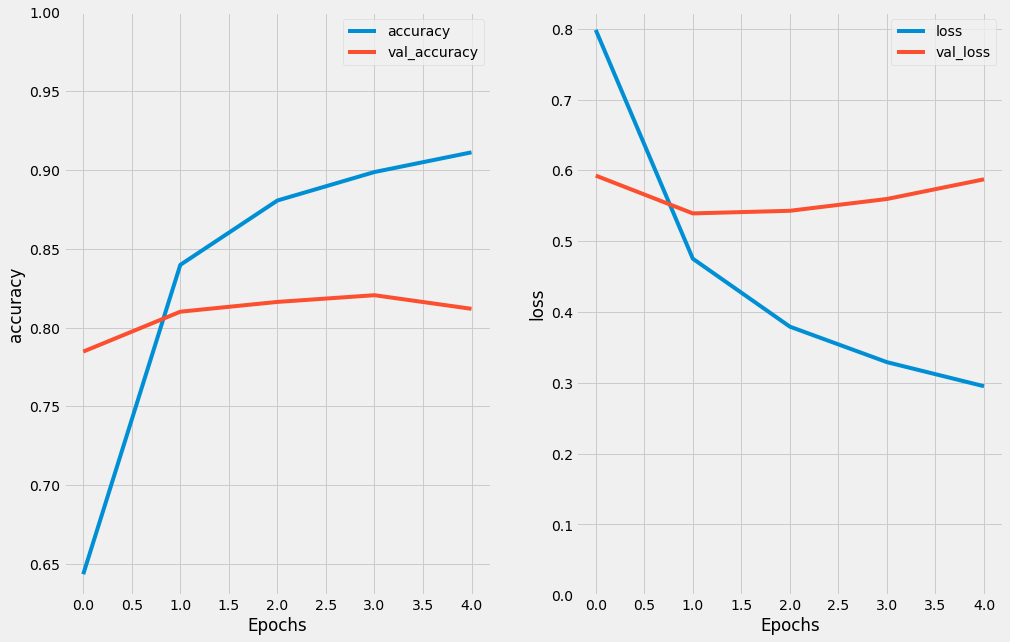

In [358]:
plt.style.use('fivethirtyeight')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_1, 'loss')
plt.ylim(0, None)

<i> If we carefully analyze the plots above it is clear that after a point the validation accuracy becomes stagnant and the validation loss starts increasing which is an indication of overfitting.

It would be great to try to handle this overfitting in the baseline model and see how much it can be imporved before moving on to a more complex architecture. </i>

In [382]:
model_2=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,128,input_length=train_text_padded.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation='softmax')
])

In [383]:
model_2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 40, 128)           1280000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
global_average_pooling1d_12  (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 27        
Total params: 1,281,059
Trainable params: 1,281,059
Non-trainable params: 0
___________________________________________

In [384]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [385]:
history_2=model_2.fit(train_text_padded,train_labels,epochs=5,validation_data=(valid_text_padded,valid_labels))

Epoch 1/5
1028/1028 [==============================] - 19s 18ms/step - loss: 0.9064 - accuracy: 0.5987 - val_loss: 0.7330 - val_accuracy: 0.7144
Epoch 2/5
1028/1028 [==============================] - 18s 18ms/step - loss: 0.6709 - accuracy: 0.7577 - val_loss: 0.6285 - val_accuracy: 0.8071
Epoch 3/5
1028/1028 [==============================] - 18s 18ms/step - loss: 0.5770 - accuracy: 0.8143 - val_loss: 0.5839 - val_accuracy: 0.8189
Epoch 4/5
1028/1028 [==============================] - 18s 18ms/step - loss: 0.5202 - accuracy: 0.8401 - val_loss: 0.5661 - val_accuracy: 0.8264
Epoch 5/5
1028/1028 [==============================] - 18s 18ms/step - loss: 0.4864 - accuracy: 0.8521 - val_loss: 0.5691 - val_accuracy: 0.8200


In [386]:
model_2.evaluate(valid_text_padded,valid_labels)

257/257 [==============================] - 0s 1ms/step - loss: 0.5691 - accuracy: 0.8200


[0.5691313743591309, 0.819995105266571]

(0.0, 0.9274471089243889)

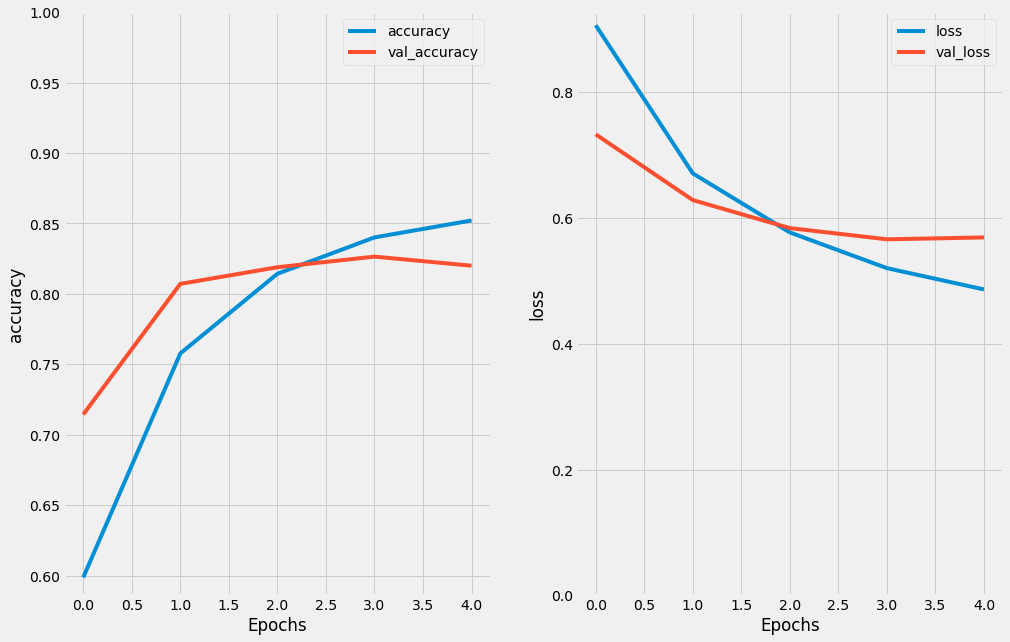

In [387]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_2, 'loss')
plt.ylim(0, None)

<i> In the above model_2 we tried using Dropout layers and regularizers which are the most basic way of dealing with overfitting it didin't effect the model that much.Still seeing the plots we can see the overfitting was reduced slightly Lets try some better ways to handle overfitting. </i> :)  

<b> <i> Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time. Lets try this with our baseline model to see if that improves the results otherwise we can move forward to more complex architectures which are best suited for Text Dataset such Recurrent Neural Networks <i> </b>


In [388]:
STEPS_PER_EPOCH = 1028

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=get_optimizer(),metrics=['accuracy'])

In [389]:
history_3 =model_2.fit(train_text_padded,train_labels,epochs=5,validation_data=(valid_text_padded,valid_labels))

Epoch 1/5
1028/1028 [==============================] - 20s 18ms/step - loss: 0.4570 - accuracy: 0.8595 - val_loss: 0.5610 - val_accuracy: 0.8264
Epoch 2/5
1028/1028 [==============================] - 19s 18ms/step - loss: 0.4354 - accuracy: 0.8667 - val_loss: 0.5705 - val_accuracy: 0.8217
Epoch 3/5
1028/1028 [==============================] - 19s 18ms/step - loss: 0.4150 - accuracy: 0.8740 - val_loss: 0.5727 - val_accuracy: 0.8230
Epoch 4/5
1028/1028 [==============================] - 19s 19ms/step - loss: 0.3975 - accuracy: 0.8789 - val_loss: 0.5932 - val_accuracy: 0.8151
Epoch 5/5
1028/1028 [==============================] - 19s 19ms/step - loss: 0.3854 - accuracy: 0.8820 - val_loss: 0.5983 - val_accuracy: 0.8176


<b> Not the amount of improvement we were expecting let's move forward to more complex architectures. </b>

<i> 2.) LSTM Based model </i>

In [395]:
STEPS_PER_EPOCH = 1028

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callback():
  
  return tf.keras.callbacks.EarlyStopping(
         monitor='val_loss', patience=3, verbose=0)

In [407]:
model_3=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,128,input_length=max_length),
    Dropout(0.3),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(16,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    tf.keras.layers.Dense(3,activation='softmax')
])
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=get_optimizer(),metrics=['accuracy'])
history_4=model_3.fit(train_text_padded,train_labels,epochs=5,validation_data=(valid_text_padded,valid_labels),callbacks=get_callback())

Epoch 1/5
1028/1028 [==============================] - 41s 38ms/step - loss: 0.9137 - accuracy: 0.5568 - val_loss: 0.6977 - val_accuracy: 0.7430
Epoch 2/5
1028/1028 [==============================] - 38s 37ms/step - loss: 0.5685 - accuracy: 0.8029 - val_loss: 0.4866 - val_accuracy: 0.8351
Epoch 3/5
1028/1028 [==============================] - 38s 37ms/step - loss: 0.4170 - accuracy: 0.8738 - val_loss: 0.4765 - val_accuracy: 0.8393
Epoch 4/5
1028/1028 [==============================] - 38s 37ms/step - loss: 0.3515 - accuracy: 0.8981 - val_loss: 0.4889 - val_accuracy: 0.8403
Epoch 5/5
1028/1028 [==============================] - 38s 37ms/step - loss: 0.3092 - accuracy: 0.9115 - val_loss: 0.5613 - val_accuracy: 0.8381


(0.0, 0.943957345187664)

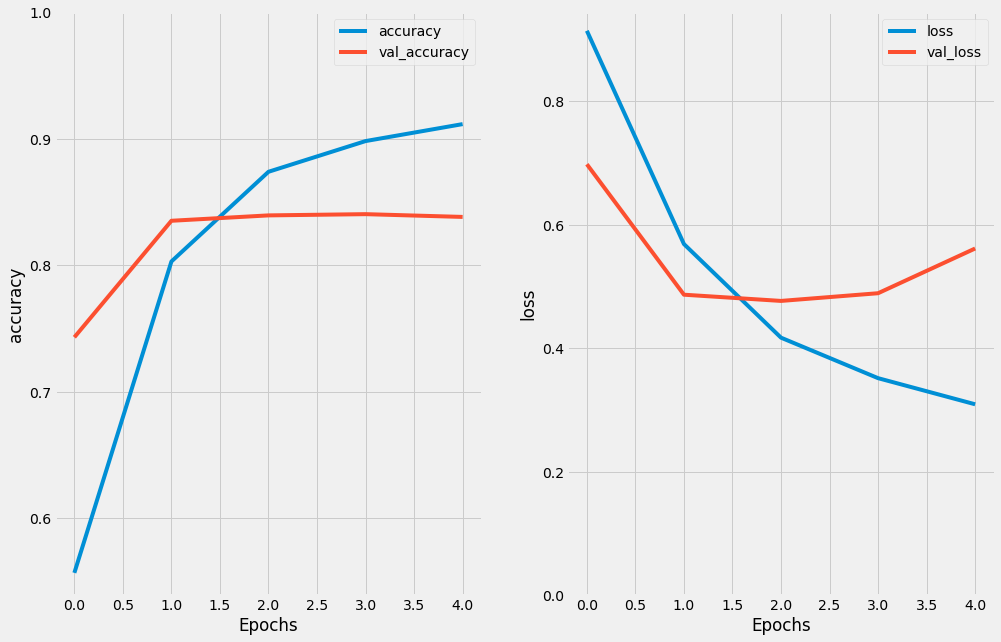

In [408]:
plt.style.use('fivethirtyeight')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_4, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_4, 'loss')
plt.ylim(0, None)

We were able to achieve almost 84% accuracy on the validation set but still there is some overfitting as seen by the plots 

In [410]:
model_4=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,128,input_length=max_length),
    Dropout(0.5),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    tf.keras.layers.Dense(3,activation='softmax')
])
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=get_optimizer(),metrics=['accuracy'])
history_4=model_4.fit(train_text_padded,train_labels,epochs=5,validation_data=(valid_text_padded,valid_labels))

Epoch 1/5
1028/1028 [==============================] - 45s 42ms/step - loss: 0.9814 - accuracy: 0.5050 - val_loss: 0.7694 - val_accuracy: 0.6906
Epoch 2/5
1028/1028 [==============================] - 41s 40ms/step - loss: 0.6655 - accuracy: 0.7609 - val_loss: 0.5495 - val_accuracy: 0.8168
Epoch 3/5
1028/1028 [==============================] - 41s 40ms/step - loss: 0.4957 - accuracy: 0.8404 - val_loss: 0.4719 - val_accuracy: 0.8393
Epoch 4/5
1028/1028 [==============================] - 42s 41ms/step - loss: 0.4285 - accuracy: 0.8697 - val_loss: 0.4707 - val_accuracy: 0.8410
Epoch 5/5
1028/1028 [==============================] - 42s 41ms/step - loss: 0.3816 - accuracy: 0.8892 - val_loss: 0.4828 - val_accuracy: 0.8362


(0.0, 1.0113595217466353)

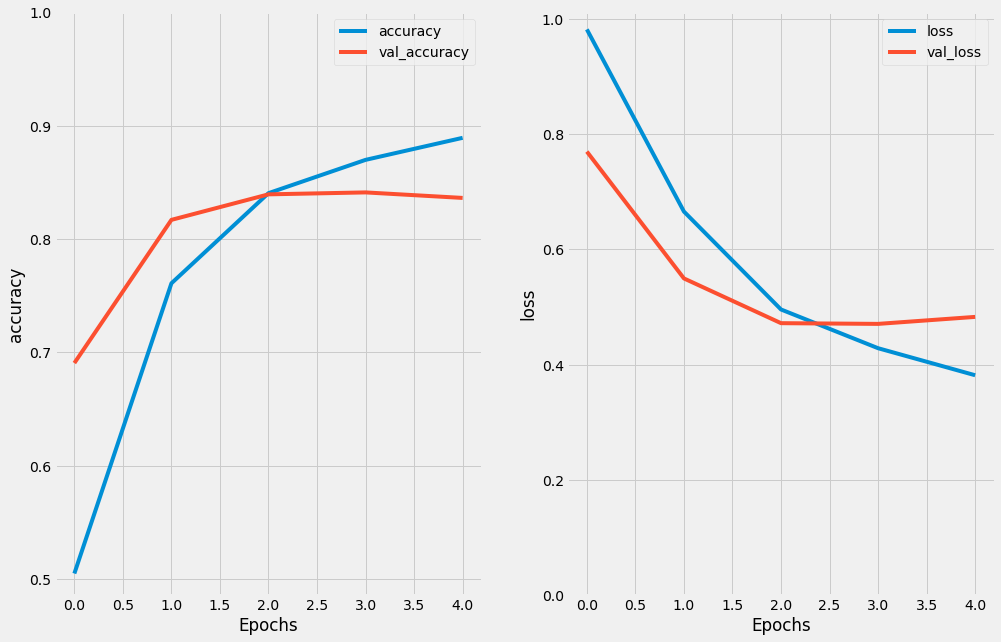

In [411]:
plt.style.use('fivethirtyeight')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_4, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_4, 'loss')
plt.ylim(0, None)

<i> This is somewhat better than the last model but still the accuracy is stagnant around 84 % on the validation set </i>

<b> Bidirectional LSTM model </b>

In [416]:
final_model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,128,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32,activation='relu'),
    Dropout(0.5),
    tf.keras.layers.Dense(3,activation='softmax')
])

final_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
history_5=final_model.fit(train_text_padded,train_labels,epochs=3,validation_data=(valid_text_padded,valid_labels),callbacks=get_callback())

Epoch 1/3
1028/1028 [==============================] - 198s 187ms/step - loss: 0.6475 - accuracy: 0.7390 - val_loss: 0.4632 - val_accuracy: 0.8408
Epoch 2/3
1028/1028 [==============================] - 191s 186ms/step - loss: 0.4036 - accuracy: 0.8716 - val_loss: 0.4484 - val_accuracy: 0.8485
Epoch 3/3
1028/1028 [==============================] - 190s 185ms/step - loss: 0.3201 - accuracy: 0.8999 - val_loss: 0.4871 - val_accuracy: 0.8442


(0.0, 0.6638787060976028)

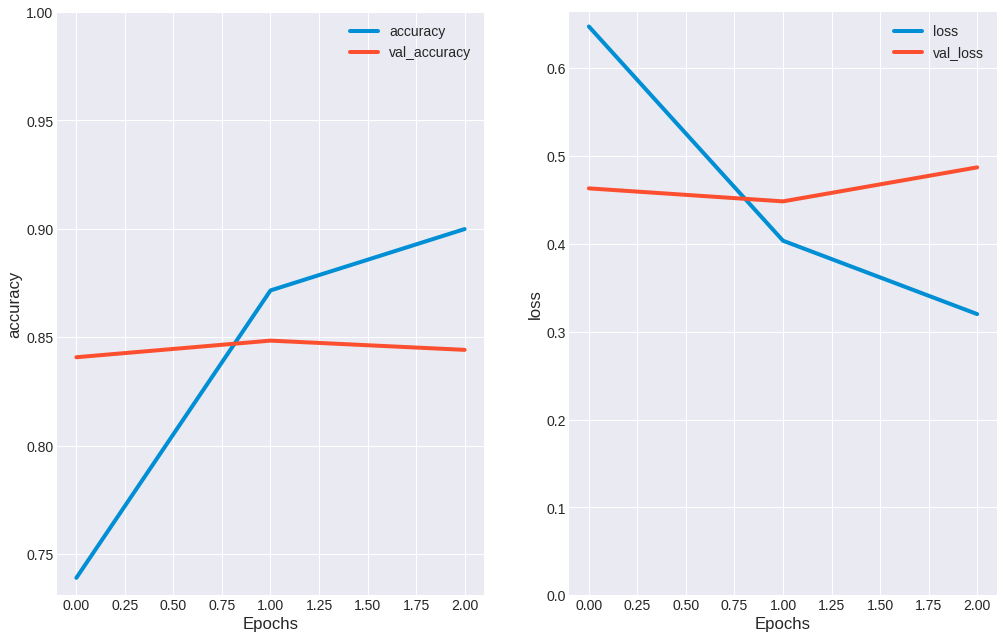

In [417]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_5, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_5, 'loss')
plt.ylim(0, None)

<b> We are able to achieve almost 85% accuracy with the final_model we can use any of the final_model or model_4 to predict on the test dataset Lets choose the final model for now. </b>

<b> Prediction on the - <i> Test set </i> </b>

In [441]:
model_3.evaluate(test_text_padded,test_labels) # We have already converted the extreme classes to the base class and the text was already cleaned above 

119/119 [==============================] - 1s 6ms/step - loss: 0.5829 - accuracy: 0.8271


[0.582904577255249, 0.8271409869194031]

We are able to achive 83% accuracy on the test which is pretty good.